In [2]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [1]:
import torch
import torchattacks
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
with torch.no_grad():
    original_weights = resnet18.conv1.weight.mean(dim=1, keepdim=True)
    resnet18.conv1.weight = torch.nn.Parameter(original_weights)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print('Training complete')

train_model(resnet18, criterion, optimizer)

In [5]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track the running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/5, Loss: 0.0676, Train Accuracy: 0.9797, Val Accuracy: 0.9855
Epoch 2/5, Loss: 0.0362, Train Accuracy: 0.9892, Val Accuracy: 0.9887
Epoch 3/5, Loss: 0.0269, Train Accuracy: 0.9917, Val Accuracy: 0.9923
Epoch 4/5, Loss: 0.0227, Train Accuracy: 0.9931, Val Accuracy: 0.9924
Epoch 5/5, Loss: 0.0198, Train Accuracy: 0.9940, Val Accuracy: 0.9922


In [6]:
classes = [
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9'
]

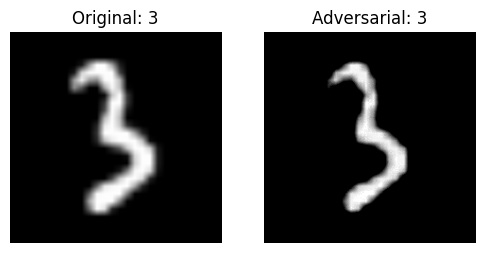

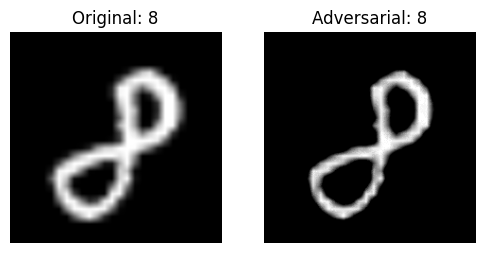

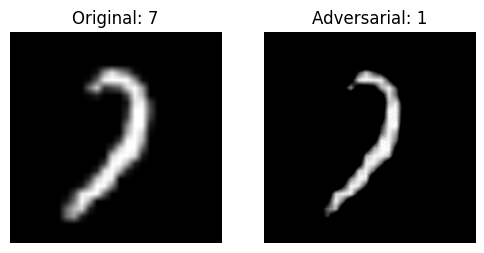

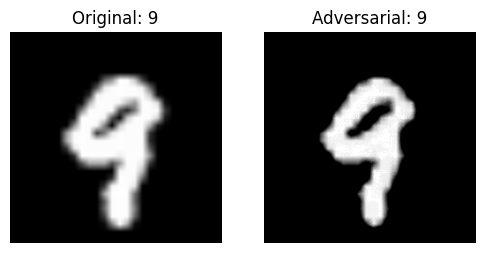

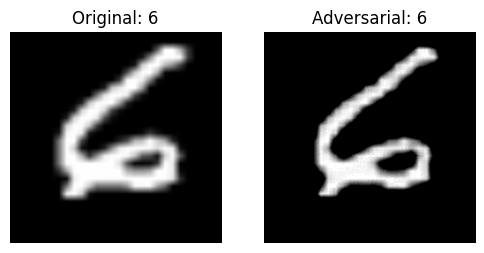

Success Rate: 0.1300


In [10]:
# Define the TPGD attack
attack_TPGD = torchattacks.TPGD(model, eps=8/255, alpha=2/255, steps=10)

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 100  # Number of samples to test

for _ in range(total_samples):
    index_TPGD = np.random.randint(0, len(test_loader.dataset))
    original_image_TPGD, original_label_TPGD = test_loader.dataset[index_TPGD]

    original_label_tensor_TPGD = torch.tensor(original_label_TPGD)
    original_image_TPGD = original_image_TPGD.unsqueeze(0).to(device)
    original_label_tensor_TPGD = original_label_tensor_TPGD.unsqueeze(0).to(device)

    adv_images_TPGD = attack_TPGD(original_image_TPGD, original_label_tensor_TPGD)

    original_prediction_TPGD = torch.argmax(model(original_image_TPGD))
    adversarial_prediction_TPGD = torch.argmax(model(adv_images_TPGD))

    if original_prediction_TPGD != adversarial_prediction_TPGD:
        successful_attacks += 1

    if _ < 5:
        show_images_side_by_side(
            original_image_TPGD.cpu().squeeze(),
            adv_images_TPGD.cpu().squeeze(),
            original_prediction_TPGD.item(),
            adversarial_prediction_TPGD.item(),
            classes
        )

# Calculate the success rate
success_rate = successful_attacks / total_samples
print(f"Success Rate: {success_rate:.4f}")

In [14]:
# Define the adversarial attacks
attacks = {
    'APGDT': torchattacks.APGDT(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, eot_iter=1, rho=.75, verbose=False, n_classes=10),
    'APGD': torchattacks.APGD(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False),
    'TIFGSM': torchattacks.TIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=1.0, resize_rate=0.9, diversity_prob=0.7, random_start=False),
}

# Function to convert a tensor to a numpy image (adjusted for grayscale images)
def tensor_to_image(tensor):
    image = tensor.cpu().numpy()
    image = image * 0.3081 + 0.1307  # De-normalize the image
    if image.shape[0] == 1:
        image = image.squeeze(0)
    return image

# Function to display original and adversarial images side by side
def show_images_side_by_side(original_image, adversarial_image, original_label, adversarial_label, classes):
    original_image = tensor_to_image(original_image)
    adversarial_image = tensor_to_image(adversarial_image)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Original image
    axs[0].imshow(original_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Original: {classes[original_label]}")

    # Adversarial image
    axs[1].imshow(adversarial_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Adversarial: {classes[adversarial_label]}")

    plt.show()

# Initialize variables to count successful attacks
attack_results = {}

for attack_name, attack in attacks.items():
    successful_attacks = 0
    total_samples = 100  # Number of samples to test

    for _ in range(total_samples):
        index = np.random.randint(0, len(test_loader.dataset))
        original_image, original_label = test_loader.dataset[index]

        original_label_tensor = torch.tensor(original_label)
        original_image = original_image.unsqueeze(0).to(device)
        original_label_tensor = original_label_tensor.unsqueeze(0).to(device)

        adv_images = attack(original_image, original_label_tensor)

        original_prediction = torch.argmax(model(original_image))
        adversarial_prediction = torch.argmax(model(adv_images))

        if original_prediction != adversarial_prediction:
            successful_attacks += 1


    # Calculate success rate for the attack
    success_rate = successful_attacks / total_samples
    attack_results[attack_name] = success_rate

# Print the success rates for each attack
print("\nSuccess Rates:")
for attack_name, success_rate in attack_results.items():
    print(f"{attack_name} Success Rate:", success_rate)

# Compare which attack has the highest success rate
best_attack = max(attack_results, key=attack_results.get)
print(f"\n{best_attack} has the highest success rate with Success Rate: {attack_results[best_attack]:.4f}")

RuntimeError: Given groups=3, weight of size [3, 1, 15, 15], expected input[1, 1, 224, 224] to have 3 channels, but got 1 channels instead